Don't be afraid, for I am with you. Don't be discouraged, for I am your God.  
I will strengthen you and help you  
I will hold you up with my victorious right hand.

# Kaggle : New York City Taxi Trip Duration

In [1]:
# Display
from IPython.display import display 
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Modeling
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrix, dmatrices

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 1. Preprocessing for Modeling

### 1.1 Data Load

In [3]:
train = pd.read_csv("train_new.csv")
test = pd.read_csv("test_new.csv")
train = train.drop(columns=['Unnamed: 0'])
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,speed(km/h),work_hour,bearing
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,2016-03-14,3,14,0,17,11,74,False,1.498521,5.0,Upper West Side,Uppe East Side,9.745591,11.856428,work,174.333195
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,2016-06-12,6,12,6,0,23,164,False,1.805507,6.0,Queens,Morningside height,12.542891,9.803659,before_work,-178.051506
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,2016-01-19,1,19,1,11,3,19,False,6.385098,16.0,Upper West Side,Harlem,16.602190,10.822201,work,-179.629721
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,2016-04-06,4,6,2,19,14,97,False,1.485498,4.0,Harlem,Harlem,9.951657,12.465721,after_work,-179.872566
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,2016-03-26,3,26,5,13,12,86,False,1.188588,5.0,LaGuardia,LaGuardia,15.176490,9.836594,work,179.990812


In [4]:
test = test.drop(columns=['Unnamed: 0.1'])
test = test.drop(columns=['Unnamed: 0'])
test = test.drop(columns=['Unnamed: 0.1.1'])
test.tail()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,work_hour,bearing
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N,2016-01-01,1,1,4,0,53,1,False,0.967438,7,Harlem,Morningside height,16.043166,before_work,0.196378
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N,2016-01-01,1,1,4,0,53,1,False,6.196343,10,Morningside height,Chelsea,15.869267,before_work,1.036410
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N,2016-01-01,1,1,4,0,53,1,False,8.153719,13,Uppe East Side,East Harlem,22.344934,before_work,173.556385
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N,2016-01-01,1,1,4,0,53,1,False,20.380748,21,Midtown,East Harlem,27.525523,before_work,0.583991
625133,id0621643,2,2016-01-01 00:00:22,2,-73.981850,40.716881,-73.969330,40.769379,N,2016-01-01,1,1,4,0,53,1,False,5.932019,13,Midtown,Uppe East Side,16.179168,before_work,0.180613


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437261 entries, 0 to 1437260
Data columns (total 28 columns):
id                    1437261 non-null object
vendor_id             1437261 non-null int64
pickup_datetime       1437261 non-null object
dropoff_datetime      1437261 non-null object
passenger_count       1437261 non-null int64
pickup_longitude      1437261 non-null float64
pickup_latitude       1437261 non-null float64
dropoff_longitude     1437261 non-null float64
dropoff_latitude      1437261 non-null float64
store_and_fwd_flag    1437261 non-null object
trip_duration         1437261 non-null int64
log_trip_duration     1437261 non-null float64
pickup_date           1437261 non-null object
pickup_month          1437261 non-null int64
pickup_day            1437261 non-null int64
pickup_weekday        1437261 non-null int64
pickup_hour           1437261 non-null int64
pickup_weekofyear     1437261 non-null int64
pickup_dayofyear      1437261 non-null int64
harsh_weather    

### 1.2 Evaluation metrics

In [5]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    difference = log_predict - log_actual
    difference = np.square(difference)
    
    mean_difference = difference.mean()
    
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)

## 2. Modeling

### 2.1 Rough Model

In [6]:
model = sm.OLS.from_formula("log_trip_duration ~ vendor_id + passenger_count + C(harsh_weather) +" 
                            "C(pickup_cluster) + C(dropoff_cluster) + C(work_hour) + C(pickup_weekday) + C(pickup_hour) + "
                            "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                            "pickup_dayofyear + np.log1p(distance) + number_of_steps + avg_speed_h + scale(bearing) +0 ", train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                 4.763e+04
Date:                Sat, 05 May 2018   Prob (F-statistic):               0.00
Time:                        23:46:10   Log-Likelihood:            -8.0433e+05
No. Observations:             1437260   AIC:                         1.609e+06
Df Residuals:                 1437190   BIC:                         1.610e+06
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

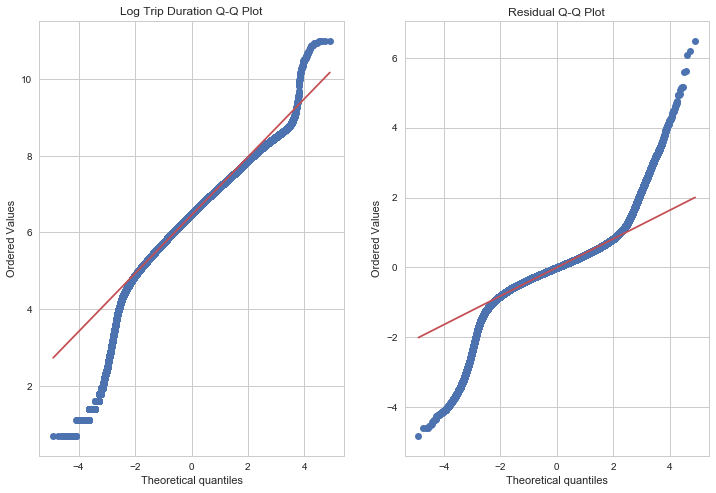

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

sp.stats.probplot(train["log_trip_duration"], plot = ax1)
ax1.set_title("Log Trip Duration Q-Q Plot")
sp.stats.probplot(result.resid, plot = ax2)
ax2.set_title("Residual Q-Q Plot")
plt.show()

In [59]:
cv = KFold(5)

print("[ R2 Score ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring="r2", cv=cv)))

[ R2 Score ]
Scores:  [0.76896554 0.76908093 0.76994288 0.75996927 0.69519352]
Mean: 0.7526304275742832


**Observe:**
  * 모든 변수들을 활용해서 모델을 만들었을 때, ** $R^2$ 값이 0.7 ** 가까이 나왔다.
  * 범주형 데이터가 많아서 다중공성성이 강하게 나타났다.

### 2.2 F-Test For Categorical Data

In [11]:
model_weather = sm.OLS.from_formula("log_trip_duration ~ C(harsh_weather) -1", data=train)
sm.stats.anova_lm(model_weather.fit())

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
C(harsh_weather),2.0,5.979518e+07,2.989759e+07,5.073151e+07,0.0
Residual,1437259.0,8.470196e+05,5.893298e-01,NaN,NaN


In [55]:
sp.stats.f_oneway(train[train["harsh_weather"]==True]["log_trip_duration"], 
                  train[train["harsh_weather"]==False]["log_trip_duration"])

F_onewayResult(statistic=62.89669632616533, pvalue=2.1799198494661314e-15)

In [57]:
sp.stats.kruskal(train[train["harsh_weather"]==True]["log_trip_duration"],
                 train[train["harsh_weather"]==False]["log_trip_duration"])

KruskalResult(statistic=72.30676478973143, pvalue=1.8421482891567556e-17)

In [9]:
model_hour = sm.OLS.from_formula("log_trip_duration ~ C(work_hour) + 0", data=train)
sm.stats.anova_lm(model_hour.fit())

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
C(work_hour),3.0,5.980275e+07,1.993425e+07,3.413031e+07,0.0
Residual,1437258.0,8.394492e+05,5.840630e-01,NaN,NaN


In [13]:
model_weekday = sm.OLS.from_formula("log_trip_duration ~ C(pickup_weekday) + 0", data=train)
sm.stats.anova_lm(model_weekday.fit())

/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_weekday),7.0,5.979931e+07,8.542759e+06,1.456682e+07,0.0
Residual,1437254.0,8.428825e+05,5.864534e-01,NaN,NaN


### 2.3 Individual OLS

### 2.3.1 Distance

In [51]:
model_dis = sm.OLS.from_formula("log_trip_duration ~ np.log1p(distance) + 0", train)
result_dis = model_dis.fit()
print(result_dis.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 9.404e+06
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        00:42:57   Log-Likelihood:            -3.2766e+06
No. Observations:             1437261   AIC:                         6.553e+06
Df Residuals:                 1437260   BIC:                         6.553e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
np.log1p(distance)     4.3883      0

In [81]:
model_dis2 = sm.OLS.from_formula("log_trip_duration ~ scale(distance) + 0", train)
result_dis2 = model_dis2.fit()
print(result_dis2.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     8355.
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        18:51:42   Log-Likelihood:            -4.7245e+06
No. Observations:             1437261   AIC:                         9.449e+06
Df Residuals:                 1437260   BIC:                         9.449e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
scale(distance)     0.4938      0.005     

### 2.3.2 Speed

In [52]:
model_speed = sm.OLS.from_formula("log_trip_duration ~ avg_speed_h + 0", train)
result_speed = model_speed.fit()
print(result_speed.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 1.870e+07
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        00:43:03   Log-Likelihood:            -2.8316e+06
No. Observations:             1437261   AIC:                         5.663e+06
Df Residuals:                 1437260   BIC:                         5.663e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
avg_speed_h     0.4198   9.71e-05   4324.521      

In [78]:
model_speed2 = sm.OLS.from_formula("log_trip_duration ~ np.log1p(avg_speed_h) + 0", train)
result_speed2 = model_speed2.fit()
print(result_speed2.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.132e+08
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        18:48:37   Log-Likelihood:            -1.5819e+06
No. Observations:             1437261   AIC:                         3.164e+06
Df Residuals:                 1437260   BIC:                         3.164e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
np.log1p(avg_speed_h)     2.39

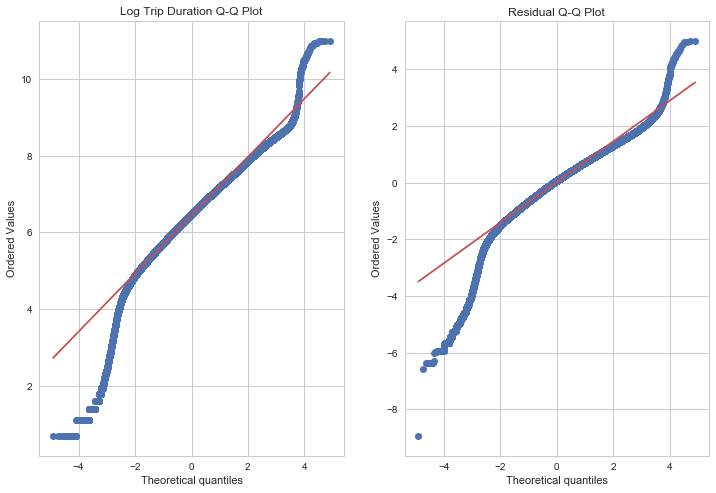

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

sp.stats.probplot(train["log_trip_duration"], plot = ax1)
ax1.set_title("Log Trip Duration Q-Q Plot")
sp.stats.probplot(result_speed2.resid, plot = ax2)
ax2.set_title("Residual Q-Q Plot")
plt.show()

In [68]:
model_loc = sm.OLS.from_formula("log_trip_duration ~ scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) - 1", train)
result_loc = model_loc.fit()
print(result_loc.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     472.7
Date:                Tue, 01 May 2018   Prob (F-statistic):               0.00
Time:                        22:59:29   Log-Likelihood:            -4.7277e+06
No. Observations:             1437261   AIC:                         9.455e+06
Df Residuals:                 1437257   BIC:                         9.456e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
scale(pickup_latitude)  

**Observe:**
  * One-way ANOVA를 통해 범주형 변수 그룹간의 유의미성을 검정하였고, 유의미하다는 결론을 내릴 수 있었다.
  * 연속형 변수에 대해서도 개별 OLS를 하였을 때, 거리와 속도가 높은 설명력을 보여주었다.

### 2.4 Remove Outlier - Cook's Distance

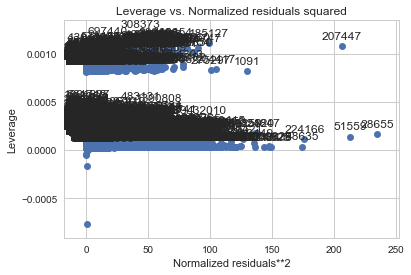

In [54]:
sm.graphics.plot_leverage_resid2(result)
plt.show()

In [ ]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

In [7]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 70)

idx_cooks = np.where(cooks_d2 > fox_cr)[0]
len(idx_cooks)

53193

In [8]:
train_ro = train.copy()

In [9]:
train_ro.drop(idx_cooks, inplace=True)
train_ro.reset_index(drop=True, inplace=True)
print(len(train_ro))
train_ro.tail()

1384068


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,speed(km/h),work_hour,bearing
1384063,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011,2016-04-08,4,8,4,13,14,99,False,1.225080,8.0,Queens,Morningside height,12.542891,5.668751,work,-178.201176
1384064,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161,2016-01-10,1,10,6,7,1,10,False,6.049836,11.0,Morningside height,LaGuardia,20.142061,33.251005,before_work,0.473628
1384065,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876,2016-04-22,4,22,4,6,16,113,False,7.824606,10.0,Chelsea,Harlem,24.263705,36.869870,before_work,-179.440954
1384066,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256,2016-01-05,1,5,1,15,1,5,False,1.092564,7.0,Queens,Uppe East Side,11.708075,10.544853,work,0.701060
1384067,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,5.293305,2016-04-05,4,5,1,14,14,96,False,1.134042,2.0,LaGuardia,LaGuardia,15.176490,20.618945,work,0.576634


### 2.5 2nd Modeling (Removing Outlier)

In [9]:
model_02 = sm.OLS.from_formula("log_trip_duration ~ vendor_id + passenger_count + C(harsh_weather) +" 
                            "C(pickup_cluster) + C(dropoff_cluster) + C(work_hour) + C(pickup_weekday) + C(pickup_hour) + "
                            "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                            "pickup_dayofyear + np.log1p(distance) + number_of_steps + avg_speed_h + scale(bearing) +0 ", train_ro)
result_02 = model_02.fit()
print(result_02.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 6.038e+04
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        02:03:05   Log-Likelihood:            -5.4325e+05
No. Observations:             1384069   AIC:                         1.087e+06
Df Residuals:                 1383999   BIC:                         1.087e+06
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

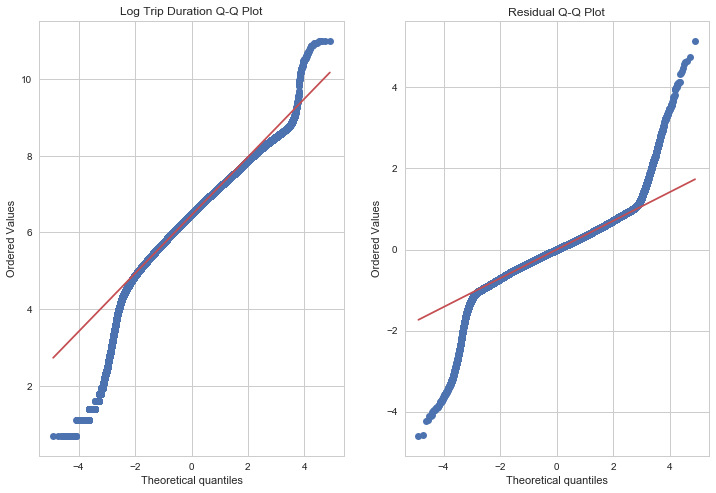

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,8))

sp.stats.probplot(train["log_trip_duration"], plot = ax1)
ax1.set_title("Log Trip Duration Q-Q Plot")
sp.stats.probplot(result_02.resid, plot = ax2)
ax2.set_title("Residual Q-Q Plot")
plt.show()

In [11]:
y, X = dmatrices("log_trip_duration ~ vendor_id + passenger_count + C(harsh_weather) +" 
                 "C(pickup_cluster) + C(dropoff_cluster) + C(work_hour) + C(pickup_weekday) + C(pickup_hour) + "
                 "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                 "pickup_dayofyear + np.log1p(distance) + number_of_steps + avg_speed_h + scale(bearing) - 1", train_ro, return_type="dataframe")

In [42]:
X_test = dmatrix("vendor_id + passenger_count + C(harsh_weather) +"
                 "C(pickup_cluster) + C(dropoff_cluster) + C(work_hour) + C(pickup_weekday) + C(pickup_hour) + "
                 "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                 "pickup_dayofyear + np.log1p(distance) + number_of_steps + avg_speed_h + scale(bearing) - 1", test, return_type="dataframe")

In [12]:
model_lr = LinearRegression().fit(X, y)
model_ridge = Ridge().fit(X, y)

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [17]:
cv = KFold(5)

print("[ R2 ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring="r2", cv=cv)))
print("-"*90)
print("[ RMSE ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring=rmse_scorer, cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring=rmse_scorer, cv=cv)))
print("-"*90)

[ R2 ]
Scores:  [0.76896554 0.76908093 0.76994288 0.75996927 0.69519352]
Mean: 0.7526304278714415
------------------------------------------------------------------------------------------
[ RMSLE ]
Scores:  [0.04670667 0.0466686  0.04661602 0.04918951 0.06501237]
Mean: 0.05083863498513631
------------------------------------------------------------------------------------------


**Observe:**
  * Cook's Distance를 통해서 Outlier를 제거 후 0.5정도 $R^2$의 상승을 보였다.

### Submission

In [18]:
X_test = dmatrix("vendor_id + passenger_count + C(harsh_weather) +"
                 "C(pickup_cluster) + C(dropoff_cluster) + C(work_hour) + C(pickup_weekday) + C(pickup_hour) + "
                 "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                 "pickup_dayofyear + np.log1p(distance) + number_of_steps + avg_speed_h + scale(bearing) - 1", test, return_type="dataframe")

In [19]:
pred = model_lr.predict(X_test)

In [20]:
import datetime
now = datetime.datetime.now()
submission_kaggle = pd.read_csv("sample_submission.csv")
submission_kaggle["trip_duration"] = np.expm1(pred)
submission_kaggle.to_csv("submission_0{}0{}{}{}.csv.gz".format(now.month, now.day, now.hour, now.minute), index=False, compression='gzip')

In [61]:
influence = result_02.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 70)

idx_cooks = np.where(cooks_d2 > fox_cr)[0]
len(idx_cooks)

51211

In [62]:
train_ro2 = train_ro.copy()

In [70]:
train_ro2.drop(idx_cooks, inplace=True)
train_ro2.reset_index(drop=True, inplace=True)
print(len(train_ro2))
train_ro2.tail()

1332859


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_date,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,speed(km/h),work_hour,bearing
1332854,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011,2016-04-08,4,8,4,13,14,99,False,1.225080,8.0,Queens,Morningside height,12.542891,5.668751,work,-178.201176
1332855,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161,2016-01-10,1,10,6,7,1,10,False,6.049836,11.0,Morningside height,LaGuardia,20.142061,33.251005,before_work,0.473628
1332856,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876,2016-04-22,4,22,4,6,16,113,False,7.824606,10.0,Chelsea,Harlem,24.263705,36.869870,before_work,-179.440954
1332857,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256,2016-01-05,1,5,1,15,1,5,False,1.092564,7.0,Queens,Uppe East Side,11.708075,10.544853,work,0.701060
1332858,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198,5.293305,2016-04-05,4,5,1,14,14,96,False,1.134042,2.0,LaGuardia,LaGuardia,15.176490,20.618945,work,0.576634


In [65]:
model_03 = sm.OLS.from_formula("log_trip_duration ~ vendor_id + passenger_count + C(harsh_weather) +" 
                            "C(pickup_cluster) + C(dropoff_cluster) + C(work_hour) + C(pickup_weekday) + C(pickup_hour) + "
                            "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                            "pickup_dayofyear + np.log1p(distance) + number_of_steps + avg_speed_h + scale(bearing) +0 ", train_ro2)
result_03 = model_03.fit()
print(result_03.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 6.311e+04
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        18:17:42   Log-Likelihood:            -4.5779e+05
No. Observations:             1332858   AIC:                         9.157e+05
Df Residuals:                 1332788   BIC:                         9.166e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

**Observe:**
  * 2회 제거 후 OLS결과, $R^2$는 0.16증가 하였으나, F-test Scores는 떨어짐
  * 1회 제거한 데이터를 활용

## 3 Random Forest

### 3.1 Data Preprocessing for Modeling

In [36]:
dfX_train = train_ro.copy()
dfX_test = test.copy()
dfy_train = train_ro.log_trip_duration.values

In [37]:
dfX_train = dfX_train.drop(columns=['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_date', 'trip_duration', 'log_trip_duration', 'speed(km/h)'])
dfX_test = dfX_test.drop(columns=['id', 'pickup_datetime', 'pickup_date'])

In [38]:
print(dfX_train.shape, dfX_test.shape)

(1384070, 21) (625134, 21)


In [13]:
dfX_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_weekofyear,pickup_dayofyear,harsh_weather,distance,number_of_steps,pickup_cluster,dropoff_cluster,avg_speed_h,work_hour,bearing
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,3,14,0,17,11,74,False,1.498521,5.0,Upper West Side,Uppe East Side,9.745591,work,174.333195
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,6,12,6,0,23,164,False,1.805507,6.0,Queens,Morningside height,12.542891,before_work,-178.051506
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,1,19,1,11,3,19,False,6.385098,16.0,Upper West Side,Harlem,16.602190,work,-179.629721
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,4,6,2,19,14,97,False,1.485498,4.0,Harlem,Harlem,9.951657,after_work,-179.872566
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,3,26,5,13,12,86,False,1.188588,5.0,LaGuardia,LaGuardia,15.176490,work,179.990812


In [39]:
feature_names = ['work_hour', 'harsh_weather', 'store_and_fwd_flag', 'pickup_cluster', 'dropoff_cluster', 'pickup_weekday', 'pickup_hour']

In [40]:
# Train 독립변수 Dummy 변환
dummies = feature_names
for feature in dummies:
    dummy_features = pd.get_dummies(dfX_train[feature], prefix=feature)
    for dummy in dummy_features:
        dfX_train[dummy] = dummy_features[dummy]
    dfX_train = dfX_train.drop([feature], 1)

In [41]:
dfX_train.fillna(0,inplace=True)
dfX_train.dtypes

vendor_id                                   int64
passenger_count                             int64
pickup_longitude                          float64
pickup_latitude                           float64
dropoff_longitude                         float64
dropoff_latitude                          float64
pickup_month                                int64
pickup_day                                  int64
pickup_weekofyear                           int64
pickup_dayofyear                            int64
distance                                  float64
number_of_steps                           float64
avg_speed_h                               float64
bearing                                   float64
work_hour_after_work                        uint8
work_hour_before_work                       uint8
work_hour_work                              uint8
harsh_weather_False                         uint8
harsh_weather_True                          uint8
store_and_fwd_flag_N                        uint8


In [42]:
dfX_train = dfX_train.drop(['pickup_weekofyear','pickup_day', 'pickup_month'], axis=1)
dfX_test = dfX_test.drop(['pickup_weekofyear','pickup_day', 'pickup_month'], axis=1)

In [ ]:
len(dfX_train.columns)

In [46]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=300, min_samples_leaf=50, min_samples_split=75)

In [48]:
rf_model.fit(dfX_train, dfy_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=75,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [50]:
predictors=dfX_train.columns

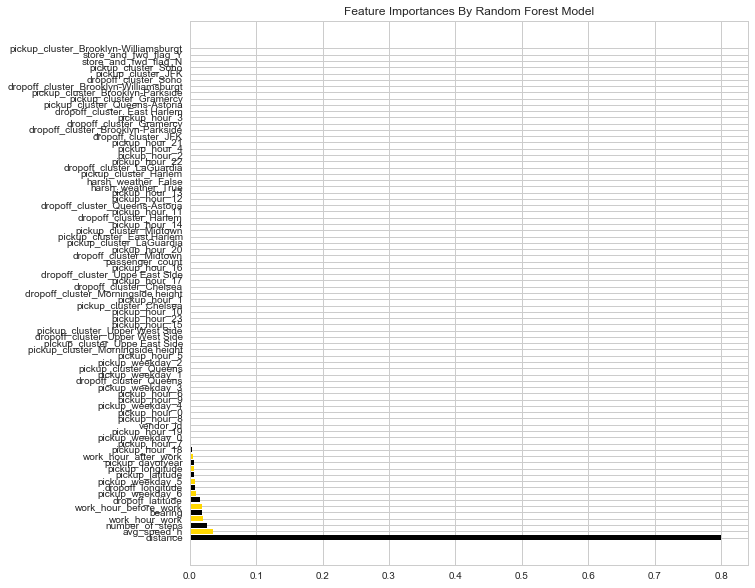

In [51]:
importances=rf_model.feature_importances_
std = np.std([rf_model.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model")
plt.barh(range(len(indices)), importances[indices],
       color=["black","gold"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal')
plt.show()

**Observe:**
  * Distance가 80% 중요도를 보였으며,  
    추가로 만든 변수인 평균속도와 Step(몇개의 골목을 지나야하는지)수 그리고 업부시간이 높은 중요도를 보였다.

> 이를 근거로 하여 모델 만들어 보기

In [52]:
# Test 독립변수 Dummy 변환
dummies = feature_names
for feature in dummies:
    dummy_features = pd.get_dummies(dfX_test[feature], prefix=feature)
    for dummy in dummy_features:
        dfX_test[dummy] = dummy_features[dummy]
    dfX_test = dfX_test.drop([feature], 1)

In [53]:
predictions=rf_model.predict(dfX_test.values)
predictions[:5]

array([6.73914127, 6.37648361, 6.14923806, 6.86108798, 5.94486074])

In [54]:
import datetime
now = datetime.datetime.now()
submission_kaggle = pd.read_csv("sample_submission.csv")
submission_kaggle["trip_duration"] = np.expm1(pred)
submission_kaggle.to_csv("submission_0{}0{}{}{}.csv.gz".format(now.month, now.day, now.hour, now.minute), index=False, compression='gzip')

## 4. Feature Selecting & Scaling

In [10]:
model_04 = sm.OLS.from_formula("log_trip_duration ~ passenger_count + C(harsh_weather) + C(work_hour) + C(pickup_weekday) + scale(np.cos(pickup_hour)) + "
                               "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                               "np.log1p(distance) + number_of_steps + np.log1p(avg_speed_h) + scale(bearing) - 1", train_ro)
result_04 = model_04.fit()
print(result_04.summary())

                            OLS Regression Results                            
Dep. Variable:      log_trip_duration   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                 2.014e+05
Date:                Sat, 05 May 2018   Prob (F-statistic):               0.00
Time:                        23:51:00   Log-Likelihood:            -5.8706e+05
No. Observations:             1384067   AIC:                         1.174e+06
Df Residuals:                 1384047   BIC:                         1.174e+06
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
C(harsh_weather)[F

In [11]:
y, X = dmatrices("log_trip_duration ~ passenger_count + C(harsh_weather) + C(work_hour) + C(pickup_weekday) + scale(np.cos(pickup_hour)) + "
                 "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                 "np.log1p(distance) + number_of_steps + np.log1p(avg_speed_h) + scale(bearing) - 1", train_ro, return_type="dataframe")

In [100]:
model_lr = LinearRegression().fit(X, y)

In [101]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

print("[ R2 ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring="r2", cv=cv)))
print("-"*70)
print("[ RMSE ]")
print("Scores: ", cross_val_score(model_lr, X, y, scoring=rmse_scorer, cv=cv))
print("Mean:", np.mean(cross_val_score(model_lr, X, y, scoring=rmse_scorer, cv=cv)))
print("-"*70)

[ R2 ]
Scores:  [0.73459118 0.73476067 0.73538784 0.7328888  0.73411533]
Mean: 0.7343487635170334
------------------------------------------------------------------------------------------
[ RMSE ]
Scores:  [0.05282062 0.05268586 0.05248195 0.05304373 0.05305181]
Mean: 0.05281679271677435
------------------------------------------------------------------------------------------


### Submission

In [111]:
X_test = dmatrix("passenger_count + C(harsh_weather) + C(work_hour) + C(pickup_weekday) + scale(np.cos(pickup_hour)) + "
                 "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                 "np.log1p(distance) + number_of_steps + np.log1p(avg_speed_h) + scale(bearing) - 1", test, return_type="dataframe")

In [112]:
pred = model_lr.predict(X_test)

In [113]:
import datetime
now = datetime.datetime.now()
submission_kaggle = pd.read_csv("sample_submission.csv")
submission_kaggle["trip_duration"] = np.expm1(pred)
submission_kaggle.to_csv("submission_0{}0{}{}{}.csv.gz".format(now.month, now.day, now.hour, now.minute), index=False, compression='gzip')

### 5. Regularized Regression

### 5.1 Mdeling

In [12]:
model_ridge = Ridge().fit(X, y)
model_lasso = Lasso().fit(X, y)
model_elastic = ElasticNet().fit(X, y)

In [103]:
# Ridge
cv = KFold(n_splits=5, shuffle=True, random_state=0)

print("[ R2 ]")
print("Scores: ", cross_val_score(model_ridge, X, y, scoring="r2", cv=cv))
print("Mean:", np.mean(cross_val_score(model_ridge, X, y, scoring="r2", cv=cv)))
print("-"*70)
print("[ RMSE ]")
print("Scores: ", cross_val_score(model_ridge, X, y, scoring=rmse_scorer, cv=cv))
print("Mean:", np.mean(cross_val_score(model_ridge, X, y, scoring=rmse_scorer, cv=cv)))
print("-"*70)

[ R2 ]
Scores:  [0.73459085 0.73476131 0.7353882  0.73288902 0.73411644]
Mean: 0.7343491644231899
----------------------------------------------------------------------
[ RMSE ]
Scores:  [0.05282065 0.05268576 0.05248194 0.05304364 0.05305167]
Mean: 0.05281673403090176
----------------------------------------------------------------------


### 5.2 Ridge Parameter Optimize

In [43]:
alphas = np.logspace(-3, 0, 50) 

In [44]:
alphas = np.append(alphas, [10, 100])

In [45]:
alphas

array([1.00000000e-03, 1.15139540e-03, 1.32571137e-03, 1.52641797e-03,
       1.75751062e-03, 2.02358965e-03, 2.32995181e-03, 2.68269580e-03,
       3.08884360e-03, 3.55648031e-03, 4.09491506e-03, 4.71486636e-03,
       5.42867544e-03, 6.25055193e-03, 7.19685673e-03, 8.28642773e-03,
       9.54095476e-03, 1.09854114e-02, 1.26485522e-02, 1.45634848e-02,
       1.67683294e-02, 1.93069773e-02, 2.22299648e-02, 2.55954792e-02,
       2.94705170e-02, 3.39322177e-02, 3.90693994e-02, 4.49843267e-02,
       5.17947468e-02, 5.96362332e-02, 6.86648845e-02, 7.90604321e-02,
       9.10298178e-02, 1.04811313e-01, 1.20679264e-01, 1.38949549e-01,
       1.59985872e-01, 1.84206997e-01, 2.12095089e-01, 2.44205309e-01,
       2.81176870e-01, 3.23745754e-01, 3.72759372e-01, 4.29193426e-01,
       4.94171336e-01, 5.68986603e-01, 6.55128557e-01, 7.54312006e-01,
       8.68511374e-01, 1.00000000e+00, 1.00000000e+01, 1.00000000e+02])

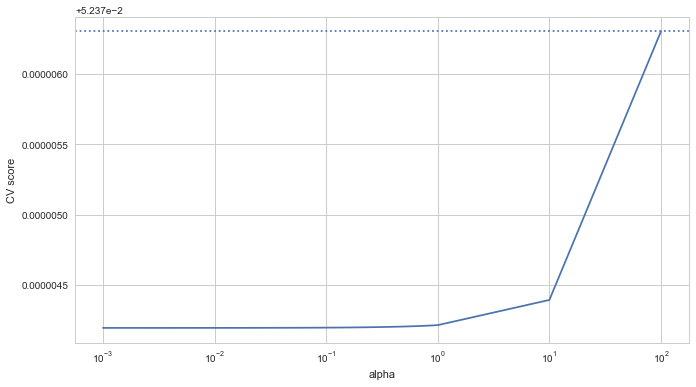

1.0


In [46]:
from sklearn.linear_model import RidgeCV

# alphas = np.logspace(-3, 0, 50)
ridge_cv = RidgeCV(alphas=alphas, cv=5).fit(X, y)
scores = list()

for alpha in alphas:
    model_ridge.alpha = alpha
    this_scores = cross_val_score(model_ridge, X, y, scoring=rmsle_scorer, cv=5)
    scores.append(np.mean(this_scores))

plt.figure(figsize=(11, 6))
plt.semilogx(alphas, scores)
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle=':')
plt.show()
print(ridge_cv.alpha_)

In [48]:
X_test = dmatrix("passenger_count + C(harsh_weather) + C(work_hour) + C(pickup_weekday) + scale(np.cos(pickup_hour)) + "
                 "scale(pickup_latitude) + scale(pickup_longitude) + scale(dropoff_latitude) + scale(dropoff_longitude) +"
                 "np.log1p(distance) + number_of_steps + np.log1p(avg_speed_h) + scale(bearing) - 1", test, return_type="dataframe")

In [49]:
pred = ridge_cv.predict(X_test)

In [51]:
import datetime
now = datetime.datetime.now()
submission_kaggle = pd.read_csv("sample_submission.csv")
submission_kaggle["trip_duration"] = np.expm1(pred)
submission_kaggle.to_csv("submission_0{}0{}{}{}.csv.gz".format(now.month, now.day, now.hour, now.minute), index=False, compression='gzip')